In [1]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Dataset

In [2]:
train = pt.dt.kang_2018()

In [3]:
train

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

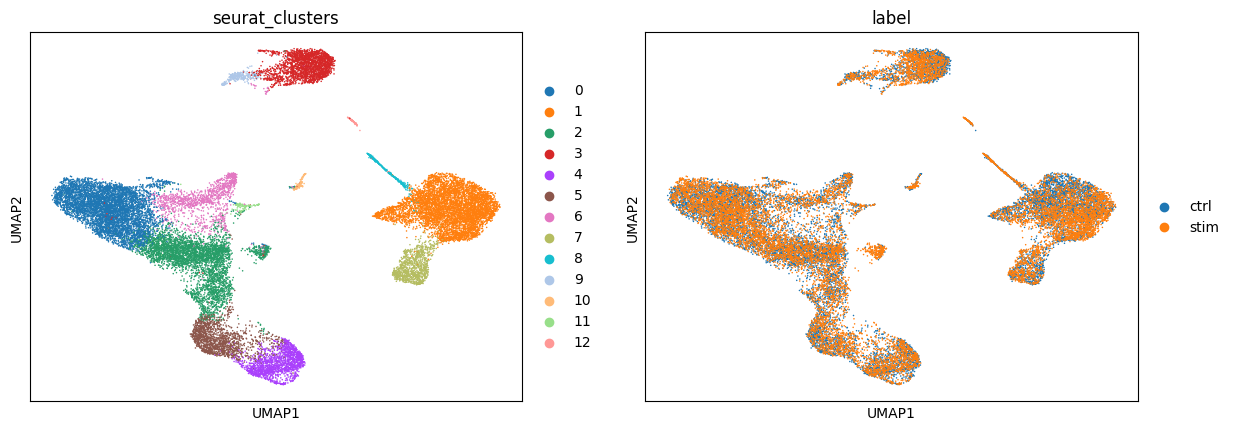

In [6]:
sc.pl.umap(train, color = ["seurat_clusters", "label"])

In [3]:
train.raw = train.copy()
sc.pp.normalize_total(train)

In [4]:
train_new = train[~((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "stim"))]
train_new = train_new.copy()

In [7]:
pt.tl.Scgen.setup_anndata(train_new, batch_key="label", labels_key="cell_type")

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


# Set up the model

In [8]:
# Set up the model
scgen = pt.tl.Scgen(train_new)

In [16]:
scgen.train(max_epochs=100, batch_size=32, accelerator="gpu", devices="auto")

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/model/base/_jaxmixin.py:68: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch operations are supported with this backend. Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  _, _, device = parse_device_args(


RuntimeError: Unknown backend mps. Available backends are ['cpu']

# Saving the model

In [14]:
scgen.save("model_perturbation_prediction.pt", overwrite=True)

In [17]:
model = scgen.load(
    dir_path="model_perturbation_prediction.pt",
    adata=train_new,  # replace with `adata` if available and necessary
    accelerator="gpu",  # or "auto" for automatic detection
    device="auto"       # or specify a device number like 0 for the first GPU
)

INFO     File model_perturbation_prediction.pt/model.pt already downloaded                                         


/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/model/base/_base_model.py:669: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch operations are supported with this backend. Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  _, _, device = parse_device_args(


INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 1/400:   0%| | 1/400 [00:00<03:46,  1.76it/s, v_num=1, train_loss_step=3.3

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/400:   0%| | 1/400 [00:00<03:47,  1.75it/s, v_num=1, train_loss_step=3.3


In [21]:
model.train(max_epochs=100, accelerator="cpu", devices=1)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|█| 100/100 [41:04<00:00, 89.07s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [41:04<00:00, 24.64s/it, v_num=1, train_loss_step


# Latent space

In [12]:
latent_X = scgen.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

RuntimeError: Trying to query inferred values from an untrained model. Please train the model first.

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


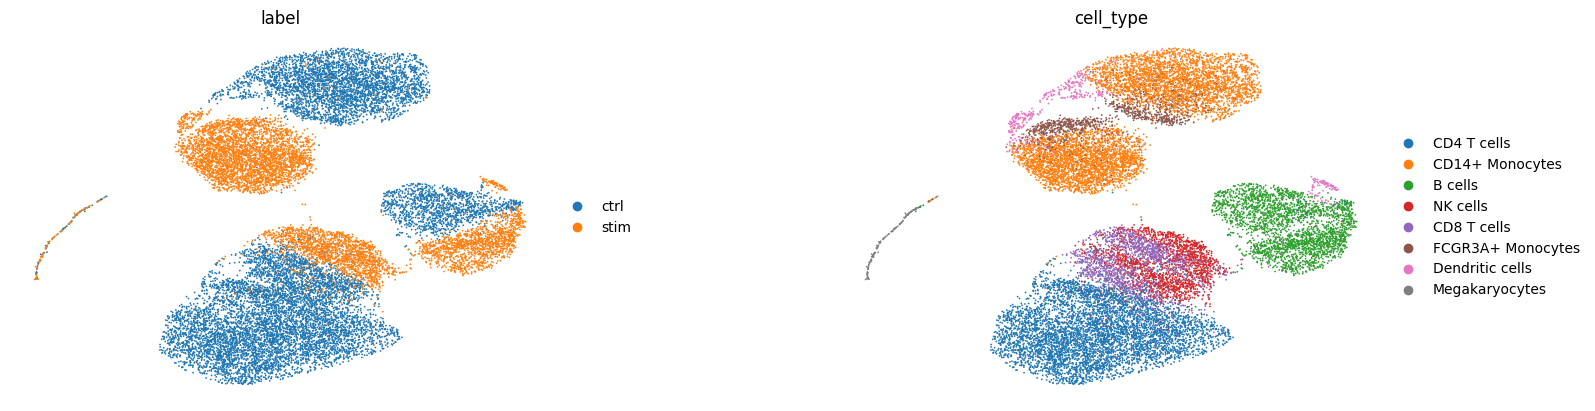

In [17]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(
    latent_adata,
    color=["label", "cell_type"],
    wspace=0.4,
    frameon=False,
    save="latentspace_batch32_klw000005_z100__100e.pdf",
)

# Prediction

In [56]:
pred, delta = model.predict(ctrl_key="ctrl", stim_key="stim", celltype_to_predict="CD4 T cells")
pred.obs["label"] = "pred"

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [38]:
pred, delta = scgen.predict(ctrl_key="ctrl", stim_key="stim", celltype_to_predict="CD4 T cells")
pred.obs["label"] = "pred"

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


RuntimeError: Trying to query inferred values from an untrained model. Please train the model first.

In [40]:
# This is the predicted, perturbed CD4 T cells
pred

AnnData object with n_obs × n_vars = 5560 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', '_scvi_batch', '_scvi_labels'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [22]:
# This could be the vector δ?
delta

array([-0.31395528, -0.47944504,  0.21823779,  2.0200014 , -0.87191945,
        0.6081141 , -0.44923273, -0.2800762 , -0.6147274 , -1.1902146 ,
       -0.87477684,  0.05015165,  0.4714377 ,  0.6625212 ,  0.03642392,
       -1.6524534 , -0.6461158 , -0.6081846 ,  0.05794266,  0.4239031 ,
       -0.97855866,  1.1117861 , -1.1067327 ,  0.2089377 , -0.1625588 ,
       -0.05458343, -1.3031712 , -0.08659679,  0.5455133 , -0.5421978 ,
        0.03812975,  0.6812346 ,  0.9099995 ,  0.70380247, -0.4122876 ,
        0.44334954, -0.02709496,  0.6253655 ,  0.28338665, -0.74199474,
        0.16805309,  0.34655085, -0.9316737 ,  0.47617257, -1.1557993 ,
        1.5351341 ,  1.1433392 ,  0.3038991 , -1.4625704 , -0.3563158 ,
        1.1387156 ,  3.1050215 ,  0.98377013,  0.09445155, -0.5220616 ,
       -0.5432928 , -1.1266742 ,  0.32627657,  0.45765367,  0.0181594 ,
       -0.67294675,  0.5966301 ,  0.29623508,  0.31214115, -0.48603427,
       -0.3125286 ,  0.15658021,  0.5839782 , -0.37153232, -0.24

# Evaluation of the prediction

In [55]:
ctrl_adata = train[((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "ctrl"))]
stim_adata = train[((train.obs["cell_type"] == "CD4 T cells") & (train.obs["label"] == "stim"))]

In [24]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/anndata/_core/merge.py:1362: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


# Embedding all real and predicted cells in one PCA plot

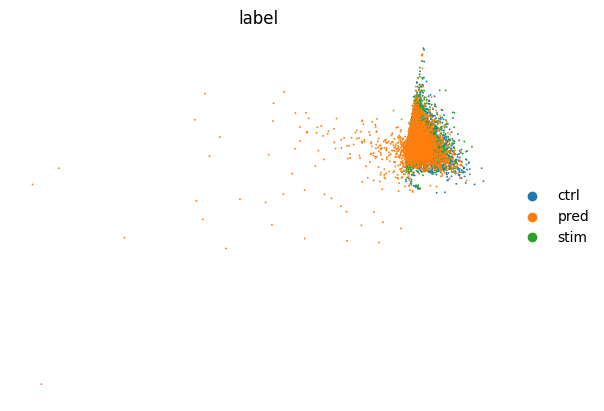

In [25]:
sc.tl.pca(eval_adata)
sc.pl.pca(
    eval_adata,
    color="label",
    frameon=False,
    #save="pred_stim_b32_klw000005_z100__100e.pdf",
)

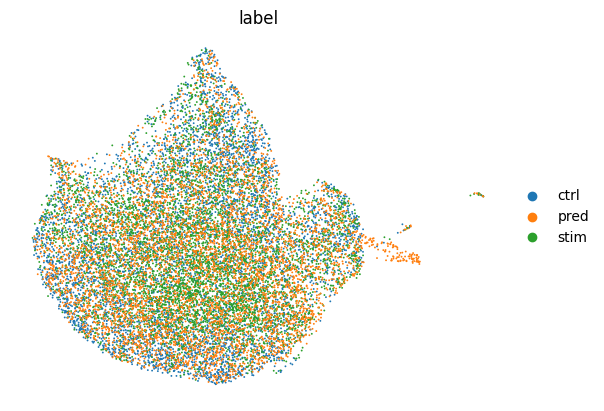

In [24]:
sc.pp.neighbors(eval_adata)
sc.tl.umap(eval_adata)
sc.pl.umap( eval_adata,
    color="label",
    frameon=False)

# Mean correlation plot

In [26]:
CD4T = train[train.obs["cell_type"] == "CD4 T cells"]
CD4T

View of AnnData object with n_obs × n_vars = 11238 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

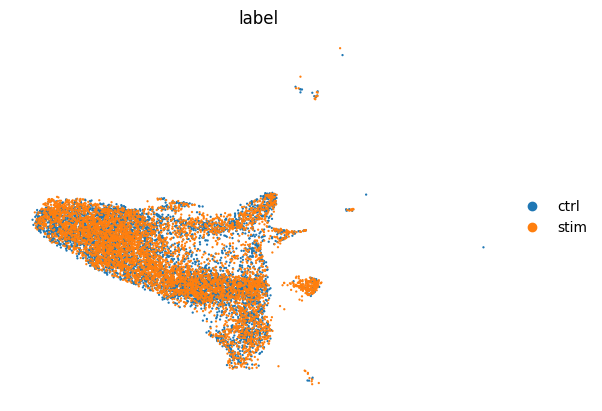

In [27]:
sc.pl.umap(CD4T,
    color="label",
    frameon=False)

In [27]:
sc.tl.rank_genes_groups(CD4T, groupby="label", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stim"]
print(diff_genes)

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['ISG15' 'IFI6' 'ISG20' ... 'EEF1A1' 'FTH1' 'RGCC']


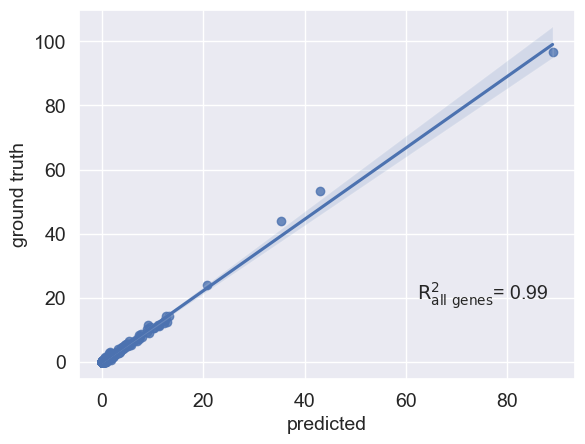

In [28]:
condition_key = scgen.adata_manager.get_state_registry(REGISTRY_KEYS.BATCH_KEY).original_key

r2_value = scgen.plot_reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stim"},
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean.pdf",
    show=True,
    legend=False,
)

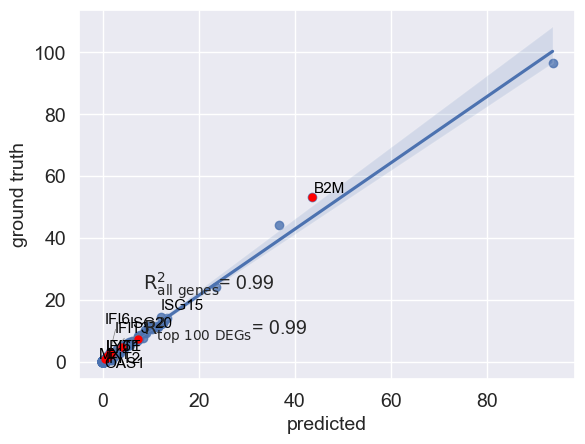

In [30]:
r2_value, r_value_diff = scgen.plot_reg_mean_plot(
    eval_adata,
    condition_key=condition_key,
    axis_keys={"x": "pred", "y": "stim"},
    gene_list=diff_genes[:10],
    top_100_genes=diff_genes,
    x_coeff=0.91,
    y_coeff=0.76,
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean_diff_genes.pdf",
    show=True,
    legend=False,
)

# Violin plot for a specific gene

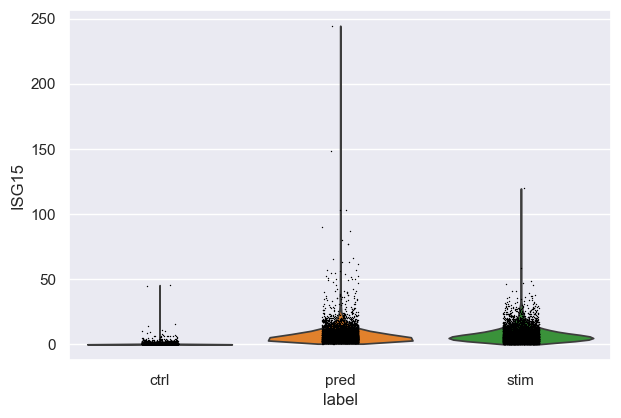

In [31]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="label")

# Which cells are most similar and dissimilar between true and predicted stimulations?

In [32]:
import pandas as pd
import numpy as np

In [34]:
eval_adata

AnnData object with n_obs × n_vars = 16798 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', '_scvi_batch', '_scvi_labels', 'batch'
    var: 'name'
    uns: 'pca', 'label_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
eval_adata.obs["label"].unique()

['ctrl', 'stim', 'pred']
Categories (3, object): ['ctrl', 'pred', 'stim']

In [38]:
# Extract the indices of 'stim' and 'pred' cells
stim_indices = eval_adata.obs[eval_adata.obs["label"] == "stim"].index
pred_indices = eval_adata.obs[eval_adata.obs["label"] == "pred"].index

In [39]:
# Extract the expression values for 'stim' and 'pred'
# Assuming that eval_adata.X is in the same shape for both 'stim' and 'pred'
stim_values = eval_adata[stim_indices].X
pred_values = eval_adata[pred_indices].X

In [43]:
stim_indices

Index(['AAACATACGAGGTG-2-1', 'AAACATACGTCGTA-2-1', 'AAACATACGTTGCA-2-1',
       'AAACATACTATGGC-2-1', 'AAACATTGACTTTC-2-1', 'AAACATTGTGCTAG-2-1',
       'AAACATTGTGTGGT-2-1', 'AAACCGTGCTGGAT-2-1', 'AAACGCACTACAGC-2-1',
       'AAACGCTGAGCACT-2-1',
       ...
       'TTTCTACTGTCGTA-2-1', 'TTTGACTGACGTAC-2-1', 'TTTGACTGCTACCC-2-1',
       'TTTGACTGCTTGGA-2-1', 'TTTGCATGACGTAC-2-1', 'TTTGCATGAGTGTC-2-1',
       'TTTGCATGCCTGAA-2-1', 'TTTGCATGCTAAGC-2-1', 'TTTGCATGGGACGA-2-1',
       'TTTGCATGTCTTAC-2-1'],
      dtype='object', name='index', length=5678)

In [44]:
pred_indices

Index(['AAACATACCATGCA-1-2', 'AAACATACGATGAA-1-2', 'AAACATACGCTTCC-1-2',
       'AAACATACGTTGTG-1-2', 'AAACATACTGCGTA-1-2', 'AAACATACTGCTGA-1-2',
       'AAACATACTGGTCA-1-2', 'AAACCGTGAGCCAT-1-2', 'AAACCGTGCATTTC-1-2',
       'AAACCGTGGAGGCA-1-2',
       ...
       'TTTCCAGAGACTAC-1-2', 'TTTCCAGAGGAGCA-1-2', 'TTTCGAACCAGATC-1-2',
       'TTTCGAACTTGCGA-1-2', 'TTTCTACTATGACC-1-2', 'TTTCTACTGGTCTA-1-2',
       'TTTGACTGAAGCAA-1-2', 'TTTGACTGCCGCTT-1-2', 'TTTGACTGTTTCGT-1-2',
       'TTTGCATGTTCATC-1-2'],
      dtype='object', name='index', length=5560)

In [40]:
# Convert to dense arrays if they are sparse matrices (common in AnnData)
if not isinstance(stim_values, np.ndarray):
    stim_values = stim_values.toarray()
if not isinstance(pred_values, np.ndarray):
    pred_values = pred_values.toarray()

## Option 1: Matching Based on Core Barcodes

In [45]:
# Extract the core part of the indices by splitting the index at '-' and taking the first part
stim_core_indices = stim_indices.str.split('-').str[0]
pred_core_indices = pred_indices.str.split('-').str[0]

# Find the common core indices
common_core_indices = stim_core_indices.intersection(pred_core_indices)

# Filter the original indices to keep only those that match the common core indices
stim_filtered_indices = stim_indices[stim_core_indices.isin(common_core_indices)]
pred_filtered_indices = pred_indices[pred_core_indices.isin(common_core_indices)]

# Subset the data using these filtered indices
stim_values = eval_adata[stim_filtered_indices].X
pred_values = eval_adata[pred_filtered_indices].X

# Convert to dense arrays if they are sparse matrices (common in AnnData)
if not isinstance(stim_values, np.ndarray):
    stim_values = stim_values.toarray()
if not isinstance(pred_values, np.ndarray):
    pred_values = pred_values.toarray()

# Compute the absolute difference between predicted and ground truth values for each gene
diff_matrix = np.abs(pred_values - stim_values)
mean_diff_per_gene = diff_matrix.mean(axis=0)

# Get gene names from the AnnData object
gene_names = eval_adata.var_names

# Create a DataFrame to store genes and their mean differences
diff_df = pd.DataFrame({
    "gene": gene_names,
    "mean_diff": mean_diff_per_gene
})

# Sort the DataFrame to find the most identical and most dissimilar genes
most_identical_genes = diff_df.sort_values("mean_diff", ascending=True).head(10)
most_dissimilar_genes = diff_df.sort_values("mean_diff", ascending=False).head(10)

print("Most Identical Genes (smallest mean difference):")
print(most_identical_genes)

print("\nMost Dissimilar Genes (largest mean difference):")
print(most_dissimilar_genes)

Most Identical Genes (smallest mean difference):
                gene  mean_diff
7841    RP11-498E2.8   0.003506
2025            LBX2   0.003844
9672        LOH12CR2   0.003945
7465   RP11-125B21.2   0.003973
3908           TIGD2   0.004007
823     RP5-1074L1.1   0.004047
11713        TBC1D24   0.004209
5159       LINC00336   0.004246
4934           GPLD1   0.004253
13264        TBC1D16   0.004327

Most Dissimilar Genes (largest mean difference):
         gene  mean_diff
8984     FTH1  38.430107
9089   MALAT1  31.703163
6440   TMSB4X  18.017759
11276     B2M  17.590134
12345   RPL13   7.872625
15395    RPL3   7.707853
7506     RPS6   7.655978
11687    RPS2   7.409872
5145    RPS18   7.408321
6655    RPS4X   6.853815


## Option 2: Aggregate by Cell Type

In [46]:
# Aggregate by cell type (assuming 'cell_type' is a column in obs)
stim_values = eval_adata[eval_adata.obs["label"] == "stim"].to_df().groupby(eval_adata.obs["cell_type"]).mean()
pred_values = eval_adata[eval_adata.obs["label"] == "pred"].to_df().groupby(eval_adata.obs["cell_type"]).mean()

# Align the data by gene names (columns)
common_genes = stim_values.columns.intersection(pred_values.columns)
stim_values = stim_values[common_genes]
pred_values = pred_values[common_genes]

# Compute the differences and proceed as before
diff_matrix = np.abs(pred_values.values - stim_values.values)
mean_diff_per_gene = diff_matrix.mean(axis=0)

# Get gene names from the common_genes array
gene_names = common_genes

# Create a DataFrame to store genes and their mean differences
diff_df = pd.DataFrame({
    "gene": gene_names,
    "mean_diff": mean_diff_per_gene
})

# Sort the DataFrame to find the most identical and most dissimilar genes
most_identical_genes = diff_df.sort_values("mean_diff", ascending=True).head(10)
most_dissimilar_genes = diff_df.sort_values("mean_diff", ascending=False).head(10)

print("Most Identical Genes (smallest mean difference):")
print(most_identical_genes)

print("\nMost Dissimilar Genes (largest mean difference):")
print(most_dissimilar_genes)

Most Identical Genes (smallest mean difference):
               gene     mean_diff
15314        DEPDC5  5.821930e-07
5248           PEX6  3.070105e-06
1875          SOCS5  4.518777e-06
5639         SERAC1  1.393212e-05
12034        SHCBP1  1.416710e-05
4824          ZFP62  1.456309e-05
9874         IGFBP6  1.845101e-05
10250         RAB35  1.958385e-05
1239   RP11-466F5.8  2.082341e-05
2426        SLC40A1  2.100319e-05

Most Dissimilar Genes (largest mean difference):
         gene  mean_diff
11276     B2M   9.621201
6440   TMSB4X   7.406956
9089   MALAT1   2.853455
5145    RPS18   2.204679
5065    HLA-B   2.125739
305      IFI6   1.731036
2766    RPL32   1.515642
4674    RPS14   1.504716
3846   CXCL10   1.399843
4673     CD74   1.228472


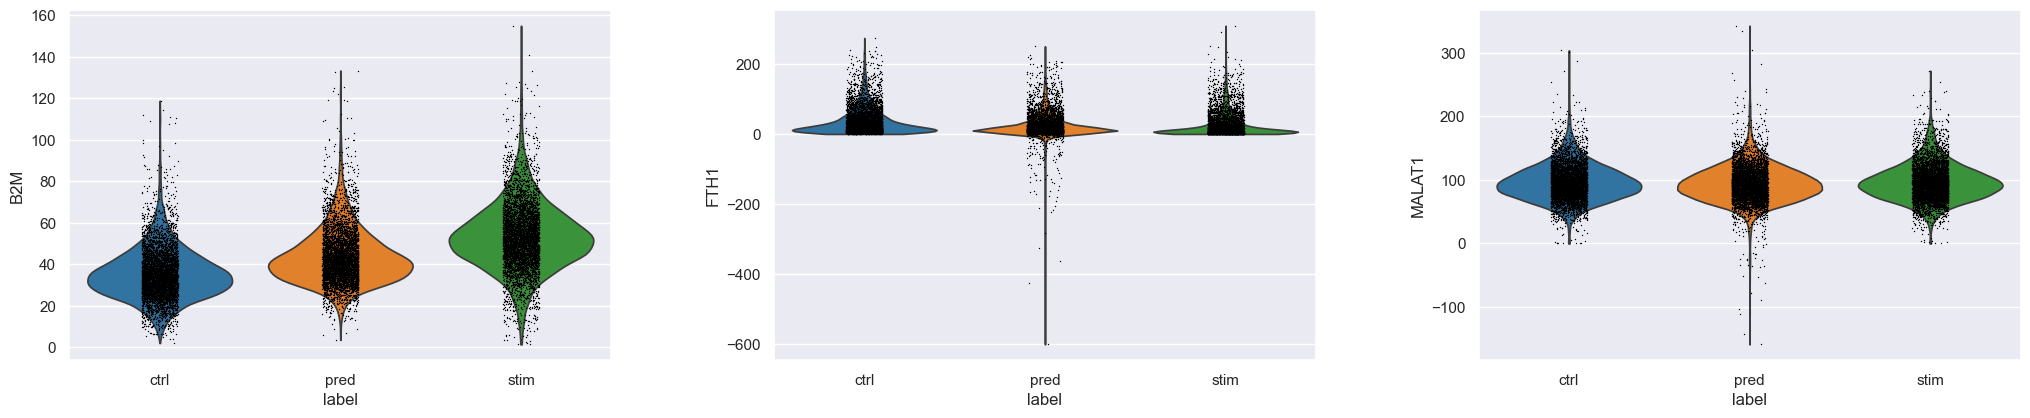

In [47]:
sc.pl.violin(eval_adata, keys=["B2M", "FTH1", "MALAT1"], groupby="label")

In [48]:
# Assuming `diff_genes` is a list or a pandas Series containing the differentially expressed genes.
diff_genes_set = set(diff_genes)  # Convert to a set for faster look-up

# Check which of the most identical genes are in diff_genes
most_identical_in_diff = most_identical_genes[most_identical_genes["gene"].isin(diff_genes_set)]

# Check which of the most dissimilar genes are in diff_genes
most_dissimilar_in_diff = most_dissimilar_genes[most_dissimilar_genes["gene"].isin(diff_genes_set)]

print("Most Identical Genes that are part of diff_genes:")
print(most_identical_in_diff)

print("\nMost Dissimilar Genes that are part of diff_genes:")
print(most_dissimilar_in_diff)

Most Identical Genes that are part of diff_genes:
               gene     mean_diff
15314        DEPDC5  5.821930e-07
5248           PEX6  3.070105e-06
1875          SOCS5  4.518777e-06
5639         SERAC1  1.393212e-05
12034        SHCBP1  1.416710e-05
4824          ZFP62  1.456309e-05
9874         IGFBP6  1.845101e-05
10250         RAB35  1.958385e-05
1239   RP11-466F5.8  2.082341e-05
2426        SLC40A1  2.100319e-05

Most Dissimilar Genes that are part of diff_genes:
         gene  mean_diff
11276     B2M   9.621201
6440   TMSB4X   7.406956
9089   MALAT1   2.853455
5145    RPS18   2.204679
5065    HLA-B   2.125739
305      IFI6   1.731036
2766    RPL32   1.515642
4674    RPS14   1.504716
3846   CXCL10   1.399843
4673     CD74   1.228472


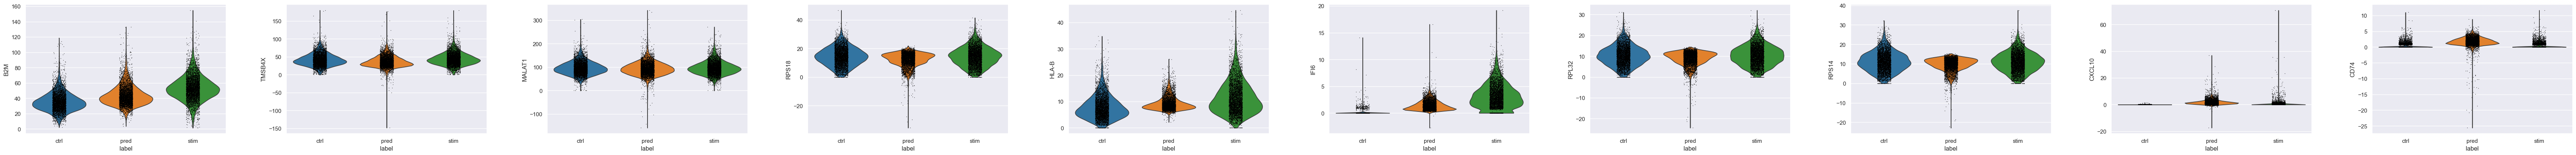

In [49]:
import scanpy as sc

# Extract gene names from the most_dissimilar_in_diff DataFrame
most_dissimilar_in_diff_genes = most_dissimilar_in_diff["gene"].tolist()

# Select the top 3 dissimilar genes for visualization (adjust the number as needed)
top_dissimilar_genes = most_dissimilar_in_diff_genes[:10]

# Create a violin plot for these genes, grouped by the "label" column
sc.pl.violin(eval_adata, keys=top_dissimilar_genes, groupby="label")

In [50]:
diff_genes

array(['ISG15', 'IFI6', 'ISG20', ..., 'EEF1A1', 'FTH1', 'RGCC'],
      dtype=object)

In [53]:
CD4T.uns

{'seurat_clusters_colors': array(['#1f77b4', '#279e68', '#e377c2', '#98df8a'], dtype='<U7'),
 'label_colors': array(['#1f77b4', '#ff7f0e'], dtype='<U7'),
 'rank_genes_groups': {'params': {'groupby': 'label',
   'reference': 'rest',
   'method': 'wilcoxon',
   'use_raw': True,
   'layer': None,
   'corr_method': 'benjamini-hochberg'},
  'names': rec.array([('RGCC', 'ISG15'), ('FTH1', 'IFI6'), ('EEF1A1', 'ISG20'), ...,
             ('ISG20', 'EEF1A1'), ('IFI6', 'FTH1'), ('ISG15', 'RGCC')],
            dtype=[('ctrl', 'O'), ('stim', 'O')]),
  'scores': rec.array([( 28.310204,  87.535835), ( 24.299402,  79.944756),
             ( 21.882048,  76.36958 ), ..., (-76.36958 , -21.882048),
             (-79.944756, -24.299402), (-87.535835, -28.310204)],
            dtype=[('ctrl', '<f4'), ('stim', '<f4')]),
  'pvals': rec.array([(2.58810762e-176, 0.00000000e+000),
             (1.98908457e-130, 0.00000000e+000),
             (3.85163198e-106, 0.00000000e+000), ...,
             (0.00000000e+000

In [51]:
# Extract DE results for the "stim" group vs. "ctrl"
de_result = CD4T.uns["rank_genes_groups"]
de_result

{'params': {'groupby': 'label',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('RGCC', 'ISG15'), ('FTH1', 'IFI6'), ('EEF1A1', 'ISG20'), ...,
            ('ISG20', 'EEF1A1'), ('IFI6', 'FTH1'), ('ISG15', 'RGCC')],
           dtype=[('ctrl', 'O'), ('stim', 'O')]),
 'scores': rec.array([( 28.310204,  87.535835), ( 24.299402,  79.944756),
            ( 21.882048,  76.36958 ), ..., (-76.36958 , -21.882048),
            (-79.944756, -24.299402), (-87.535835, -28.310204)],
           dtype=[('ctrl', '<f4'), ('stim', '<f4')]),
 'pvals': rec.array([(2.58810762e-176, 0.00000000e+000),
            (1.98908457e-130, 0.00000000e+000),
            (3.85163198e-106, 0.00000000e+000), ...,
            (0.00000000e+000, 3.85163198e-106),
            (0.00000000e+000, 1.98908457e-130),
            (0.00000000e+000, 2.58810762e-176)],
           dtype=[('ctrl', '<f8'), ('stim', '<f8')]),
 'pvals_adj': rec.arr

In [54]:
# Get the lists of genes, log-fold change, and p-values for the comparison
genes = de_result["names"]["stim"]  # Top genes for the "stim" group
logfc = de_result["logfoldchanges"]["stim"]  # Log fold change values
pvals = de_result["pvals"]["stim"]  # P-values
pvals_adj = de_result["pvals_adj"]["stim"]  # Adjusted p-values (optional)

# Create a DataFrame with the necessary columns
diff_genes_df = pd.DataFrame({
    "gene": genes,
    "logFC": logfc,
    "pval": pvals,
    "pval_adj": pvals_adj  # Optional if you want to use adjusted p-values
})

# Preview the DataFrame
print(diff_genes_df.head())

    gene      logFC  pval  pval_adj
0  ISG15  12.651348   0.0       0.0
1   IFI6   8.477605   0.0       0.0
2  ISG20   7.137801   0.0       0.0
3  IFIT3   8.639895   0.0       0.0
4  IFIT1   8.133961   0.0       0.0


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

/Users/georgegavriilidis/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


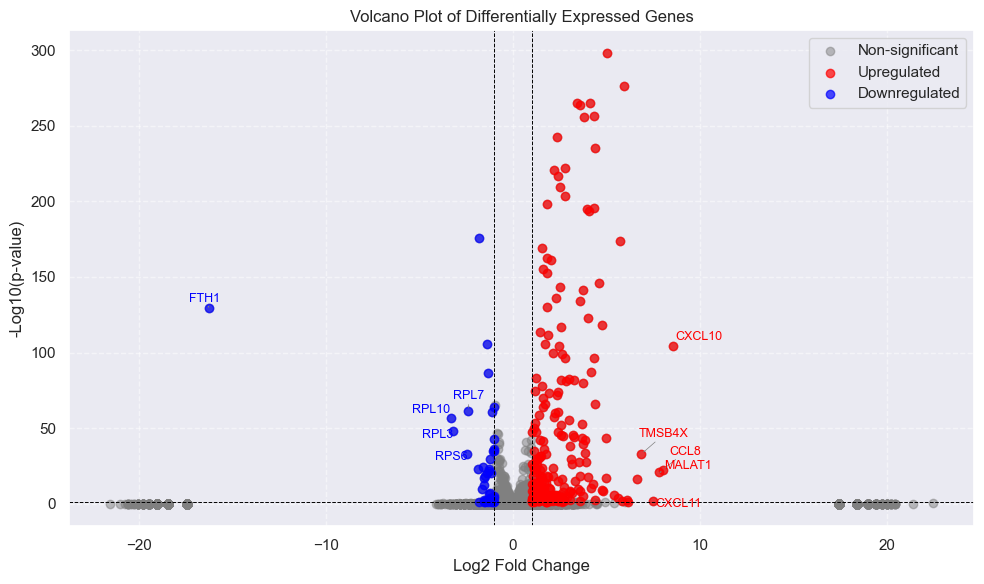

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Ensure your DataFrame contains the required columns
# diff_genes_df = pd.DataFrame(...) # Replace with your actual DataFrame

# Calculate -log10(p-value)
diff_genes_df["-log10(pval)"] = -np.log10(diff_genes_df["pval"])

# Define thresholds for significance and logFC (adjust as needed)
pval_threshold = 0.05
logfc_threshold = 1

# Create the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(
    diff_genes_df["logFC"], 
    diff_genes_df["-log10(pval)"], 
    c='gray', 
    alpha=0.5, 
    label='Non-significant'
)

# Highlight significant genes with large fold changes
significant_up = diff_genes_df[
    (diff_genes_df["pval"] < pval_threshold) & (diff_genes_df["logFC"] > logfc_threshold)
]
significant_down = diff_genes_df[
    (diff_genes_df["pval"] < pval_threshold) & (diff_genes_df["logFC"] < -logfc_threshold)
]

plt.scatter(
    significant_up["logFC"], 
    significant_up["-log10(pval)"], 
    c='red', 
    alpha=0.7, 
    label='Upregulated'
)

plt.scatter(
    significant_down["logFC"], 
    significant_down["-log10(pval)"], 
    c='blue', 
    alpha=0.7, 
    label='Downregulated'
)

# Add labels and title
plt.axhline(-np.log10(pval_threshold), color='black', linestyle='--', linewidth=0.7)
plt.axvline(logfc_threshold, color='black', linestyle='--', linewidth=0.7)
plt.axvline(-logfc_threshold, color='black', linestyle='--', linewidth=0.7)
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot of Differentially Expressed Genes")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Filter genes by -log10(pval) between 1.3 and 300
filtered_genes = diff_genes_df[
    (diff_genes_df["-log10(pval)"] >= 1.3) & (diff_genes_df["-log10(pval)"] <= 300)
]

# Select the top 5 upregulated and top 5 downregulated genes with the largest logFC
top_up_logfc = filtered_genes.nlargest(5, "logFC")
top_down_logfc = filtered_genes.nsmallest(5, "logFC")

# Prepare text annotations
texts = []

# Annotate top upregulated genes
for i, row in top_up_logfc.iterrows():
    texts.append(
        plt.text(row["logFC"], row["-log10(pval)"], row["gene"],
                 fontsize=9, ha='left', va='bottom', color='red')
    )

# Annotate top downregulated genes
for i, row in top_down_logfc.iterrows():
    texts.append(
        plt.text(row["logFC"], row["-log10(pval)"], row["gene"],
                 fontsize=9, ha='right', va='bottom', color='blue')
    )

# Adjust the text to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Display the plot
plt.show()

# Distribution metrics

In [29]:
# Initialize Distance with a chosen metric, here 'wasserstein'
distance_metric = pt.tools.Distance(metric="edistance")

In [35]:
stim_adata

View of AnnData object with n_obs × n_vars = 5678 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [42]:
stim_adata.X = stim_adata.X.tocsr()  # Convert to sparse format

In [36]:
ctrl_adata

View of AnnData object with n_obs × n_vars = 5560 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [43]:
ctrl_adata.X = ctrl_adata.X.tocsr()

In [46]:
from scipy.sparse import csr_matrix

# Convert pred.X to sparse CSR format
pred.X = csr_matrix(pred.X)

In [45]:
pred

AnnData object with n_obs × n_vars = 5560 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', '_scvi_batch', '_scvi_labels'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [57]:
# Extract PCA embeddings
pert_data_pca = np.array(stim_adata.obsm["X_pca"])  # Real perturbed data
pred_data_pca = np.array(pred.obsm["X_pca"])        # Simulated perturbed data
ctrl_data_pca = np.array(ctrl_adata.obsm["X_pca"])  # Control data

In [58]:
# Use the PCA-transformed data in `compare_distance`
perturbation_score_simple = distance_metric.compare_distance(
    pert=pert_data_pca, 
    pred=pred_data_pca, 
    ctrl=ctrl_data_pca, 
    mode="simple"
)

In [59]:
# Use the PCA-transformed data in `compare_distance`
perturbation_score_scaled = distance_metric.compare_distance(
    pert=pert_data_pca, 
    pred=pred_data_pca, 
    ctrl=ctrl_data_pca, 
    mode="scaled"
)

In [60]:
# Display the computed scores
print(f"Perturbation Score (simple mode): {perturbation_score_simple}")
print(f"Perturbation Score (scaled mode, fit to both perturbed and control): {perturbation_score_scaled}")

Perturbation Score (simple mode): 1.2307473840417604
Perturbation Score (scaled mode, fit to both perturbed and control): 0.0006871839376624977


In [47]:
perturbation_score_simple = distance_metric.compare_distance(
    pert=stim_adata, 
    pred=pred, 
    ctrl=ctrl_adata, 
    mode="simple"
)

TypeError: Value View of AnnData object with n_obs × n_vars = 5678 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap' with type <class 'anndata._core.anndata.AnnData'> is not a valid JAX type

In [ ]:
# Set the target number of cells
target_cells = 6300

# Calculate the proportion to sample
sample_fraction = target_cells / adata.n_obs

# Perform downsampling
adata_downsampled = adata[np.random.choice(adata.obs_names, size=target_cells, replace=False)]

## E-distance

In [65]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "edistance", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

      distance  pvalue  significant  pvalue_adj  significant_adj
ctrl  0.000000   1.000        False    1.000000            False
stim  8.990463   0.001         True    0.002997            False
pred  6.541138   0.001         True    0.002997            False


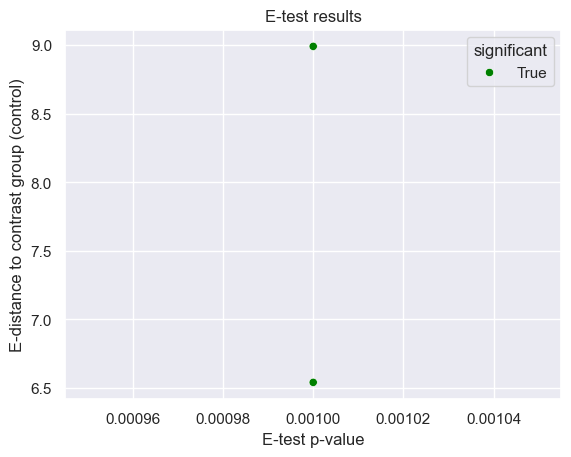

In [66]:
import seaborn as sns

with sns.axes_style("darkgrid"):
    sns.scatterplot(
        data=tab[tab.index != contrast],
        x="pvalue",
        y="distance",
        hue="significant",
        palette={True: "green", False: "red"},
    )
plt.title("E-test results")
plt.xlabel("E-test p-value")
plt.ylabel("E-distance to contrast group (control)")
plt.show()

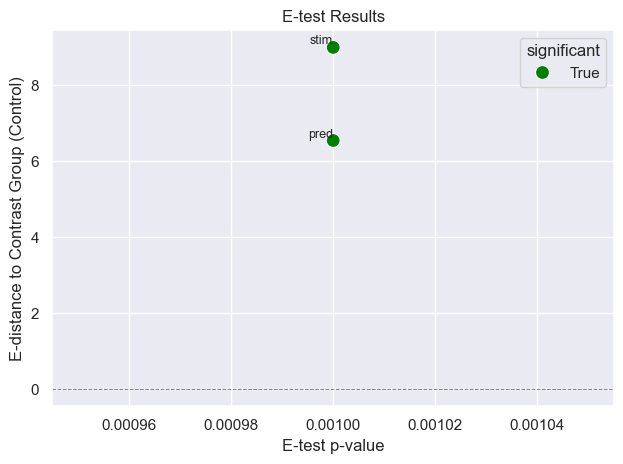

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `tab` is a DataFrame containing the E-distance test results
# and `contrast` is set to the control group (e.g., "ctrl").

# Filter out the control group (contrast) from the plot
data_to_plot = tab[tab.index != contrast]

# Create the scatter plot with Seaborn
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_to_plot,
        x="pvalue",
        y="distance",
        hue="significant",
        palette={True: "green", False: "red"},
        s=100  # Size of the points for better visibility
    )
    
# Add plot titles and labels
plt.title("E-test Results")
plt.xlabel("E-test p-value")
plt.ylabel("E-distance to Contrast Group (Control)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Optional: Add a horizontal line at y=0

# Annotate each point with its name (index)
for idx, row in data_to_plot.iterrows():
    plt.text(
        row["pvalue"], 
        row["distance"], 
        idx,  # Use the index (name) of the row as the label
        fontsize=9, 
        ha='right', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

## MMD

In [71]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "mmd", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

        distance  pvalue  significant  pvalue_adj  significant_adj
ctrl    0.000000   1.000        False    1.000000            False
stim  691.597626   0.001         True    0.002997            False
pred  478.178482   0.001         True    0.002997            False


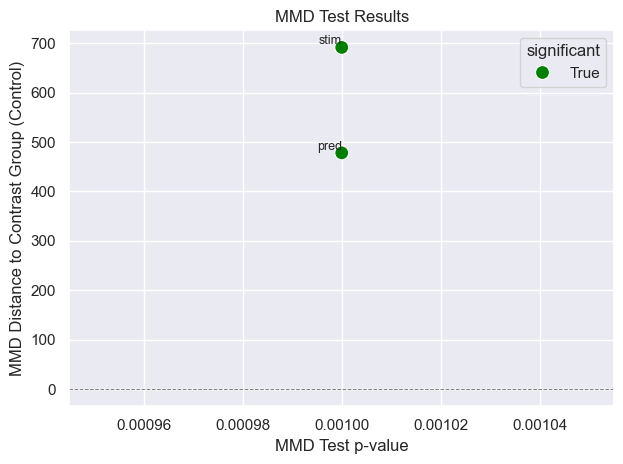

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `tab` is a DataFrame containing the MMD test results
# and `contrast` is set to the control group (e.g., "ctrl").

# Filter out the control group (contrast) from the plot
data_to_plot = tab[tab.index != contrast]

# Create the scatter plot with Seaborn
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_to_plot,
        x="pvalue",
        y="distance",  # Adjust this to the column that contains MMD values if necessary
        hue="significant",
        palette={True: "green", False: "red"},
        s=100  # Size of the points for better visibility
    )
    
# Add plot titles and labels
plt.title("MMD Test Results")
plt.xlabel("MMD Test p-value")
plt.ylabel("MMD Distance to Contrast Group (Control)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Optional: Add a horizontal line at y=0

# Annotate each point with its name (index)
for idx, row in data_to_plot.iterrows():
    plt.text(
        row["pvalue"], 
        row["distance"], 
        idx,  # Use the index (name) of the row as the label
        fontsize=9, 
        ha='right', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

## Mahalanobis

In [73]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "mahalanobis", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

       distance  pvalue  significant  pvalue_adj  significant_adj
ctrl   0.000000   1.000        False    1.000000            False
stim   3.064555   0.001         True    0.002997            False
pred  28.227736   0.001         True    0.002997            False


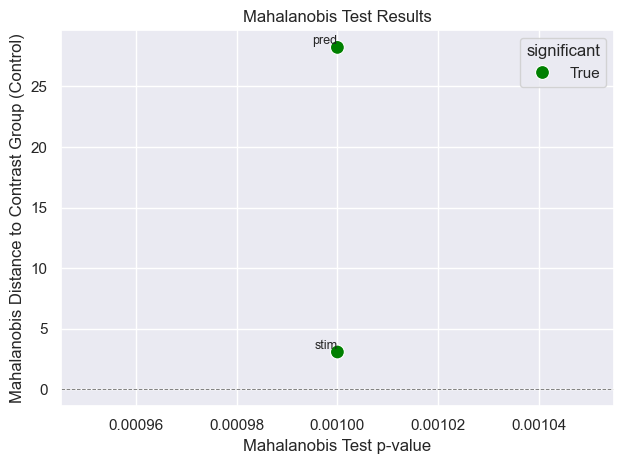

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the control group (contrast) from the plot
data_to_plot = tab[tab.index != contrast]

# Create the scatter plot with Seaborn
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_to_plot,
        x="pvalue",
        y="distance",  # Adjust this to the column that contains MMD values if necessary
        hue="significant",
        palette={True: "green", False: "red"},
        s=100  # Size of the points for better visibility
    )
    
# Add plot titles and labels
plt.title("Mahalanobis Test Results")
plt.xlabel("Mahalanobis Test p-value")
plt.ylabel("Mahalanobis Distance to Contrast Group (Control)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Optional: Add a horizontal line at y=0

# Annotate each point with its name (index)
for idx, row in data_to_plot.iterrows():
    plt.text(
        row["pvalue"], 
        row["distance"], 
        idx,  # Use the index (name) of the row as the label
        fontsize=9, 
        ha='right', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

## Wasserstein distance

In [75]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "wasserstein", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

KeyboardInterrupt: 

## r2 distance

In [76]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "r2_distance", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

      distance  pvalue  significant  pvalue_adj  significant_adj
ctrl  0.000000   1.000        False    1.000000            False
stim  4.916074   0.001         True    0.002997            False
pred  6.246716   0.001         True    0.002997            False


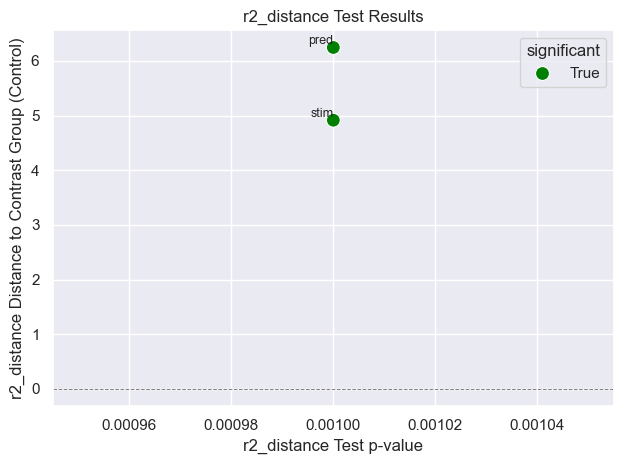

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the control group (contrast) from the plot
data_to_plot = tab[tab.index != contrast]

# Create the scatter plot with Seaborn
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_to_plot,
        x="pvalue",
        y="distance",  # Adjust this to the column that contains MMD values if necessary
        hue="significant",
        palette={True: "green", False: "red"},
        s=100  # Size of the points for better visibility
    )
    
# Add plot titles and labels
plt.title("r2_distance Test Results")
plt.xlabel("r2_distance Test p-value")
plt.ylabel("r2_distance Distance to Contrast Group (Control)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Optional: Add a horizontal line at y=0

# Annotate each point with its name (index)
for idx, row in data_to_plot.iterrows():
    plt.text(
        row["pvalue"], 
        row["distance"], 
        idx,  # Use the index (name) of the row as the label
        fontsize=9, 
        ha='right', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

## KL divergence

In [78]:
import pertpy as pt

# Define the key in `obs` that indicates the conditions (e.g., "label")
obs_key = "label"  # Change this to the correct column name in your `eval_adata.obs`
contrast = "ctrl"  # Use "ctrl" as the reference group for comparison

# Create the DistanceTest object using E-distance and the desired parameters
etest = pt.tl.DistanceTest(
    "sym_kldiv", 
    n_perms=1000, 
    obsm_key="X_pca",  # Use PCA-reduced data; change to other keys if needed
    alpha=0.0015  # Significance threshold
)

# Run the test, which compares the distributions of the specified groups against the control
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

# View the results
print(tab)

Output()

       distance  pvalue  significant  pvalue_adj  significant_adj
ctrl   0.000000   1.000        False    1.000000            False
stim   0.098126   0.001         True    0.002997            False
pred  23.885000   0.001         True    0.002997            False


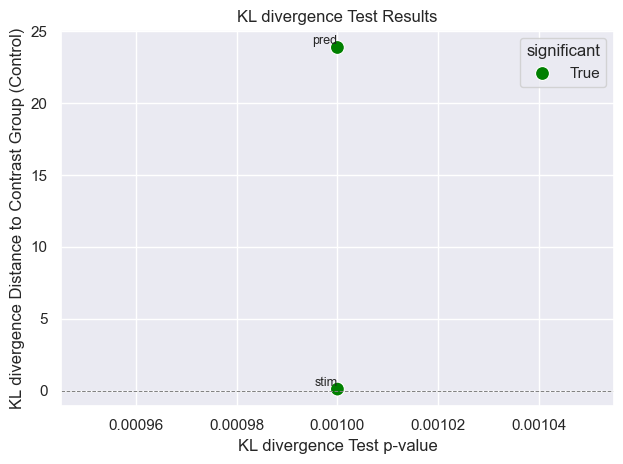

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the control group (contrast) from the plot
data_to_plot = tab[tab.index != contrast]

# Create the scatter plot with Seaborn
with sns.axes_style("darkgrid"):
    ax = sns.scatterplot(
        data=data_to_plot,
        x="pvalue",
        y="distance",  # Adjust this to the column that contains MMD values if necessary
        hue="significant",
        palette={True: "green", False: "red"},
        s=100  # Size of the points for better visibility
    )
    
# Add plot titles and labels
plt.title("KL divergence Test Results")
plt.xlabel("KL divergence Test p-value")
plt.ylabel("KL divergence Distance to Contrast Group (Control)")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)  # Optional: Add a horizontal line at y=0

# Annotate each point with its name (index)
for idx, row in data_to_plot.iterrows():
    plt.text(
        row["pvalue"], 
        row["distance"], 
        idx,  # Use the index (name) of the row as the label
        fontsize=9, 
        ha='right', 
        va='bottom'
    )

plt.tight_layout()

# Show the plot
plt.show()

## Paradigmatic visualisations for distance metrics

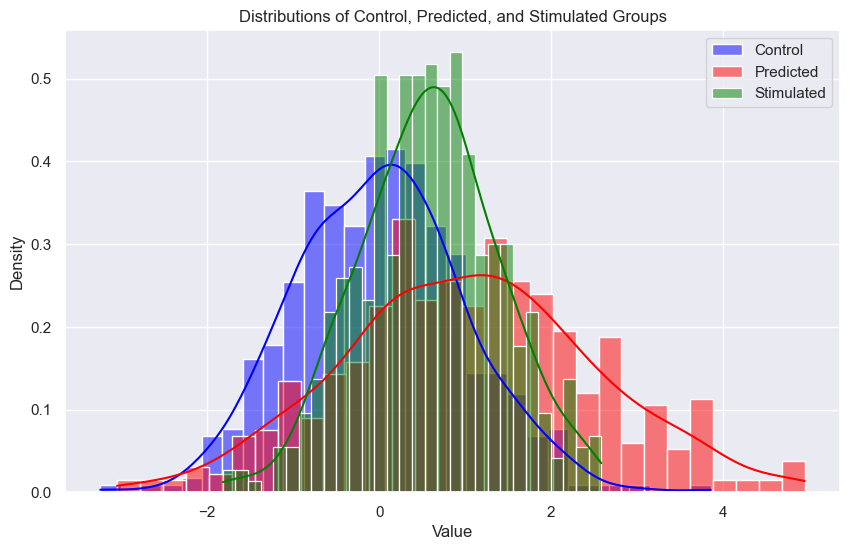

E-distance between Control and Predicted: 0.5301
MMD between Control and Predicted: 0.1362


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist, mahalanobis
from scipy.stats import entropy, wasserstein_distance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

# Create two simple 1D Gaussian distributions
np.random.seed(42)
dist_1 = np.random.normal(loc=0, scale=1, size=500)  # Control group
dist_2 = np.random.normal(loc=1, scale=1.5, size=500)  # Predicted group with shift
dist_3 = np.random.normal(loc=0.5, scale=0.8, size=500)  # Stimulated group

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(dist_1, kde=True, color='blue', label='Control', stat='density', bins=30)
sns.histplot(dist_2, kde=True, color='red', label='Predicted', stat='density', bins=30)
sns.histplot(dist_3, kde=True, color='green', label='Stimulated', stat='density', bins=30)
plt.title('Distributions of Control, Predicted, and Stimulated Groups')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# E-distance
def e_distance(x, y):
    dist_between = np.mean(cdist(x.reshape(-1, 1), y.reshape(-1, 1)))
    dist_x = np.mean(cdist(x.reshape(-1, 1), x.reshape(-1, 1)))
    dist_y = np.mean(cdist(y.reshape(-1, 1), y.reshape(-1, 1)))
    return 2 * dist_between - dist_x - dist_y

e_dist = e_distance(dist_1, dist_2)
print(f"E-distance between Control and Predicted: {e_dist:.4f}")

# MMD with RBF kernel
def compute_mmd(x, y, gamma=1.0):
    X_kernel = rbf_kernel(x.reshape(-1, 1), x.reshape(-1, 1), gamma=gamma)
    Y_kernel = rbf_kernel(y.reshape(-1, 1), y.reshape(-1, 1), gamma=gamma)
    XY_kernel = rbf_kernel(x.reshape(-1, 1), y.reshape(-1, 1), gamma=gamma)
    return X_kernel.mean() + Y_kernel.mean() - 2 * XY_kernel.mean()

mmd_value = compute_mmd(dist_1, dist_2)
print(f"MMD between Control and Predicted: {mmd_value:.4f}")

# Mahalanobis distance between the means of two distributions
cov_matrix = np.cov(dist_1)
mahalanobis_dist = mahalanobis(np.mean(dist_1), np.mean(dist_2), np.linalg.inv(cov_matrix))
print(f"Mahalanobis distance between Control and Predicted: {mahalanobis_dist:.4f}")

# Wasserstein distance (Earth Mover's Distance)
wasserstein_dist = wasserstein_distance(dist_1, dist_2)
print(f"Wasserstein distance between Control and Predicted: {wasserstein_dist:.4f}")

# KL divergence (symmetrized)
dist_1_hist, bin_edges = np.histogram(dist_1, bins=30, density=True)
dist_2_hist, _ = np.histogram(dist_2, bins=bin_edges, density=True)
dist_1_hist += 1e-9  # Add small value to avoid division by zero
dist_2_hist += 1e-9
kl_divergence = entropy(dist_1_hist, dist_2_hist) + entropy(dist_2_hist, dist_1_hist)
print(f"Symmetrized KL divergence between Control and Predicted: {kl_divergence:.4f}")

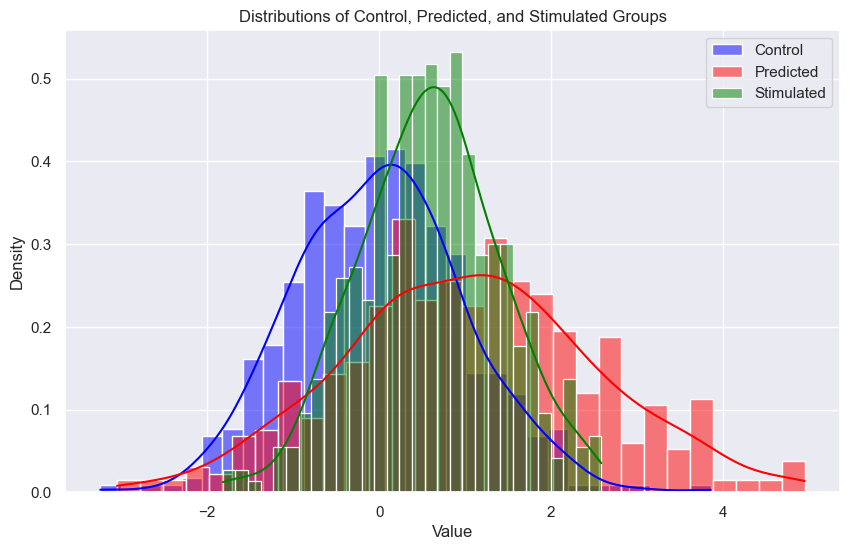

E-distance between Control and Predicted: 0.5301
MMD between Control and Predicted: 0.1362


ValueError: shapes (1,) and (500,500) not aligned: 1 (dim 0) != 500 (dim 0)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist, mahalanobis
from scipy.stats import entropy, wasserstein_distance
from sklearn.metrics.pairwise import rbf_kernel

# Create two simple 1D Gaussian distributions
np.random.seed(42)
dist_1 = np.random.normal(loc=0, scale=1, size=500)  # Control group
dist_2 = np.random.normal(loc=1, scale=1.5, size=500)  # Predicted group with shift
dist_3 = np.random.normal(loc=0.5, scale=0.8, size=500)  # Stimulated group

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(dist_1, kde=True, color='blue', label='Control', stat='density', bins=30)
sns.histplot(dist_2, kde=True, color='red', label='Predicted', stat='density', bins=30)
sns.histplot(dist_3, kde=True, color='green', label='Stimulated', stat='density', bins=30)
plt.title('Distributions of Control, Predicted, and Stimulated Groups')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# E-distance
def e_distance(x, y):
    dist_between = np.mean(cdist(x.reshape(-1, 1), y.reshape(-1, 1)))
    dist_x = np.mean(cdist(x.reshape(-1, 1), x.reshape(-1, 1)))
    dist_y = np.mean(cdist(y.reshape(-1, 1), y.reshape(-1, 1)))
    return 2 * dist_between - dist_x - dist_y

e_dist = e_distance(dist_1, dist_2)
print(f"E-distance between Control and Predicted: {e_dist:.4f}")

# MMD with RBF kernel
def compute_mmd(x, y, gamma=1.0):
    X_kernel = rbf_kernel(x.reshape(-1, 1), x.reshape(-1, 1), gamma=gamma)
    Y_kernel = rbf_kernel(y.reshape(-1, 1), y.reshape(-1, 1), gamma=gamma)
    XY_kernel = rbf_kernel(x.reshape(-1, 1), y.reshape(-1, 1), gamma=gamma)
    return X_kernel.mean() + Y_kernel.mean() - 2 * XY_kernel.mean()

mmd_value = compute_mmd(dist_1, dist_2)
print(f"MMD between Control and Predicted: {mmd_value:.4f}")

# Mahalanobis distance between the means of two distributions
# Stack distributions into a 2D array for covariance calculation
data = np.vstack((dist_1, dist_2))
cov_matrix = np.cov(data, rowvar=False)

# Calculate the mean vectors of the distributions
mean_1 = np.mean(dist_1)
mean_2 = np.mean(dist_2)

# Compute the Mahalanobis distance between the mean vectors
mahalanobis_dist = mahalanobis([mean_1], [mean_2], np.linalg.inv(cov_matrix))
print(f"Mahalanobis distance between Control and Predicted: {mahalanobis_dist:.4f}")

# Wasserstein distance (Earth Mover's Distance)
wasserstein_dist = wasserstein_distance(dist_1, dist_2)
print(f"Wasserstein distance between Control and Predicted: {wasserstein_dist:.4f}")

# KL divergence (symmetrized)
dist_1_hist, bin_edges = np.histogram(dist_1, bins=30, density=True)
dist_2_hist, _ = np.histogram(dist_2, bins=bin_edges, density=True)
dist_1_hist += 1e-9  # Add small value to avoid division by zero
dist_2_hist += 1e-9
kl_divergence = entropy(dist_1_hist, dist_2_hist) + entropy(dist_2_hist, dist_1_hist)
print(f"Symmetrized KL divergence between Control and Predicted: {kl_divergence:.4f}")